In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

**Image Transformations**: Here, a set of image transformations is defined using the **albumentations** library. These transformations include resizing the image, padding if necessary, normalizing pixel values, and converting the image to a tensor.

In [4]:
transforms_img = A.Compose(
    [
        A.LongestMaxSize(max_size=416),
        A.PadIfNeeded(
            min_height=416, min_width=416, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ])

**Constants and Configurations**: This section defines various constants and configurations for the YOLOv3 model. These include confidence threshold, mean average precision (mAP) IoU threshold, non-maximum suppression (NMS) IoU threshold, image size, and anchor boxes.

In [5]:
CONF_THRESHOLD = 0.05
MAP_IOU_THRESH = 0.5
NMS_IOU_THRESH = 0.45
IMAGE_SIZE = 416
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Class Labels**: This section defines the class labels used for object detection. classes is a list of class names, and num_class stores the total number of classes.

In [6]:
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
           'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
           'train', 'tvmonitor']
num_class = len(classes)

**Importing Utility Functions and Classes**: This block imports the utility functions and classes required for the YOLOv3 model, including functions for converting cell predictions to bounding boxes, performing non-maximum suppression, calculating mean average precision, the dataset class for YOLO, and the YOLOv3 model itself.

In [7]:
from utils import cells_to_bboxes, non_max_suppression, intersection_over_union, mean_average_precision
from dataset import YOLODataset

In [8]:
from models import YOLOv3

**Loading the Pre-trained Model**: This block loads the pre-trained YOLOv3 model with the specified number of classes. The model is loaded onto the selected device (GPU if available) and its state dictionary is updated with the pre-trained weights.

In [9]:
model = YOLOv3(num_classes=num_class).to(device)
weight = 'yolov3_pascal_78.1map.pth.tar'
chkpt = torch.load(weight, map_location=device)
model.load_state_dict(chkpt['state_dict'])

<All keys matched successfully>

**Loading and Pre-processing an Example Image**: This section loads an example image and performs some pre-processing steps. The image is read using OpenCV (**cv2.imread**), converted from BGR to RGB color space, and stored in the img variable. The original height and width of the image are stored in ori_h and ori_w, respectively. The image is then transformed using the defined image transformations (**transforms_img**), and the transformed image tensor is stored in imgT. The transformed image tensor is also converted back to a numpy array (img2) for visualization purposes. The new height and width of the transformed image are stored in new_h and new_w.

In [10]:
img = cv2.cvtColor(cv2.imread('skynews-boeing-737-plane_5435020.jpg'), cv2.COLOR_BGR2RGB)
ori_h, ori_w = img.shape[0], img.shape[1]
imgT = transforms_img(image=img)['image']
img2 = imgT.permute(1,2,0).numpy()
new_h, new_w = img2.shape[0], img2.shape[1]

**Displaying the Original Image**: This block displays the original image using matplotlib's **imshow** function.

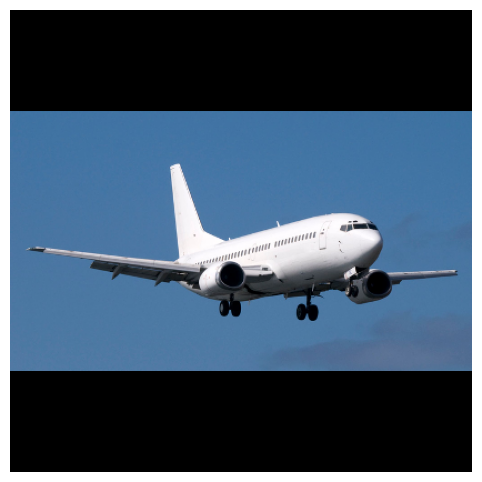

In [11]:
plt.figure(figsize=(10,6))
plt.imshow(img2)
plt.axis('off')
plt.show()

**Preparing the Image Tensor for Inference**: Here, the transformed image tensor (**imgT**) is unsqueezed to add an extra dimension representing the batch size. This is necessary for passing the image tensor through the YOLOv3 model.

In [12]:
imgT = imgT.unsqueeze(0)

**Performing the Forward Pass**: This section performs the forward pass of the YOLOv3 model on the image tensor. The image tensor is moved to the appropriate device (CPU or GPU), and the predictions are obtained by passing the image tensor through the model.

In [13]:
with torch.no_grad():    # deactivate autograd engine to reduce memory usage and speed up computations
    imgT = imgT.to(device)    # send the input tensor to the device (CPU or GPU)
    predictions = model(imgT)    # feed the input tensor to the model to get the output tensor

**Extracting Bounding Boxes from Predictions**: In this section, the bounding boxes are extracted from the predictions of the YOLOv3 model. The predictions are processed for each scale, and the bounding boxes are computed using the cells_to_bboxes function. The anchor boxes are scaled based on the stride (S) and multiplied by the corresponding scale. The bounding boxes are appended to the bboxes list.

In [14]:
bboxes = [[]]
for i in range(3):
    S = predictions[i].shape[2]
    anchor = torch.tensor([*ANCHORS[i]]).to(device) * S
    boxes_scale_i = cells_to_bboxes(
        predictions[i], anchor, S=S, is_preds=True
    )
    for idx, (box) in enumerate(boxes_scale_i):
        bboxes[idx] += box

In [15]:
len(bboxes[0])

10647

**Non-Maximum Suppression and Visualizing Detected Objects**: This section performs non-maximum suppression to remove redundant bounding boxes and visualizes the detected objects on the original image.

In [16]:
detections = non_max_suppression(
    bboxes[0],
    iou_threshold=0.45,
    threshold=0.25,
    box_format="midpoint",
)

In [17]:
len(detections)

1

In [18]:
detections

[[0.0,
  0.8749909400939941,
  0.47005289793014526,
  0.5079185366630554,
  0.7578311562538147,
  0.462798148393631]]

In [20]:
gain = min(new_h / ori_h, new_w / ori_w)  # gain  = old / new
pad = (new_w - ori_w * gain) / 2, (new_h - ori_h * gain) / 2  # wh padding
for detection in detections:
    idx = int(detection[0])
    confidence = detection[1]
    cx, cy, cw, ch = detection[2:6]
    
    startX = int((cx-(cw/2))*new_w)
    startY = int((cy-(ch/2))*new_h)
    endX = int((cx+(cw/2))*new_w)
    endY = int((cy+(ch/2))*new_h)
    
    startX = int((startX-pad[0])/gain)
    startY = int((startY-pad[1])/gain)
    endX = int((endX-pad[0])/gain)
    endY = int((endY-pad[1])/gain)

    label = "{}: {:.2f}%".format(classes[idx], confidence * 100)
    print("[INFO] {}".format(label))
    shape = [(startX, startY), (endX, endY)]
    
    cv2.rectangle(img, (startX, startY), (endX, endY), (255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    cv2.putText(img,label, (startX, startY), 0, 1, (255, 0, 0), thickness=1, lineType=cv2.LINE_AA)

[INFO] aeroplane: 87.50%


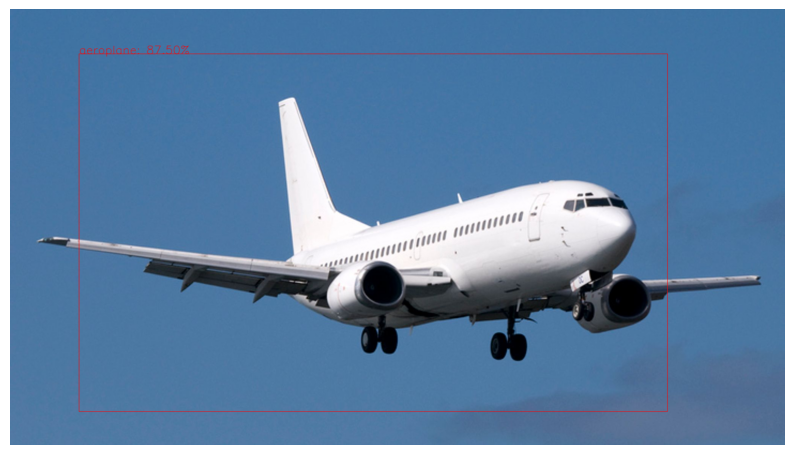

In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis('off')
plt.show()

**Define the transformation pipeline for test data**: In this block, we define the transformation pipeline for the test data using albumentations. The pipeline includes resizing the image, padding the image, normalizing the image, and converting it to a PyTorch tensor. The bbox_params specify the format of the bounding boxes.

In [22]:
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

**Create the test dataset and data loader**: Then, we create the test dataset test_dataset using the YOLODataset class, providing the necessary file paths, transformation pipeline, scales, image directory, label directory, and anchors. In this block, we create the test data loader test_loader using the DataLoader class. We pass the test_dataset to it and set the batch size, number of workers, pin memory, shuffle, and drop last options as per our requirements.

In [23]:
test_dataset = YOLODataset(
        './PASCAL_VOC/test.csv',
        transform=test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        img_dir='./PASCAL_VOC/images/',
        label_dir='./PASCAL_VOC/labels/',
        anchors=ANCHORS,
    )
    
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
)

**Model Evaluation and Accuracy Tracking**

In this block, we set the model to evaluation mode using model.eval() and initialize variables to track the accuracy of the model's predictions.

In [24]:
model.eval()
tot_class_preds, correct_class = 0, 0
tot_noobj, correct_noobj = 0, 0
tot_obj, correct_obj = 0, 0

In this block, we iterate over the test data loader and perform the model evaluation. For each batch, we move the input data x to the device (e.g., GPU) and obtain the model predictions out using model(x) inside the torch.no_grad() context to disable gradient computation. Then, we iterate over the three scales of predictions and calculate the accuracy metrics. We check if the object is present (obj) and if the object is absent (noobj). We compare the predicted class with the true class labels and count the correct class predictions. We also compare the objectness predictions with the true objectness labels to count the correct object and non-object predictions.

In [25]:
for idx, (x, y) in enumerate(tqdm(test_loader)):
    x = x.to(device)
    with torch.no_grad():
        out = model(x)

    for i in range(3):
        y[i] = y[i].to(device)
        obj = y[i][..., 0] == 1 # in paper this is Iobj_i
        noobj = y[i][..., 0] == 0  # in paper this is Iobj_i

        correct_class += torch.sum(
            torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
        )
        tot_class_preds += torch.sum(obj)

        obj_preds = torch.sigmoid(out[i][..., 0]) > CONF_THRESHOLD
        correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
        tot_obj += torch.sum(obj)
        correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
        tot_noobj += torch.sum(noobj)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [01:12<00:00,  2.15it/s]


In this block, we print the class accuracy, non-object accuracy, and object accuracy by calculating the respective percentages based on the tracked values.

In [26]:
print(f"Class accuracy is: {(correct_class/(tot_class_preds+1e-16))*100:2f}%")
print(f"No obj accuracy is: {(correct_noobj/(tot_noobj+1e-16))*100:2f}%")
print(f"Obj accuracy is: {(correct_obj/(tot_obj+1e-16))*100:2f}%")

Class accuracy is: 95.569405%
No obj accuracy is: 98.133835%
Obj accuracy is: 96.536438%


**Prediction and Mean Average Precision Calculation**

In this block, we initialize variables to track the predicted bounding boxes and true bounding boxes.

In [27]:
train_idx = 0
all_pred_boxes = []
all_true_boxes = []

In this block, we iterate over the test data loader again to obtain predictions and calculate mean average precision (MAP). For each batch, we move the input data x to the device and obtain the model predictions predictions. We iterate over the three scales and convert the predicted cells to bounding boxes using the cells_to_bboxes function. Similarly, we convert the true cells to bounding boxes. Then, for each example in the batch, we apply non-maximum suppression to the predicted boxes using the non_max_suppression function and store the predicted and true boxes in all_pred_boxes and all_true_boxes, respectively.

In [28]:
for batch_idx, (x, labels) in enumerate(tqdm(test_loader)):
    x = x.to(device)

    with torch.no_grad():
        predictions = model(x)

    batch_size = x.shape[0]
    bboxes = [[] for _ in range(batch_size)]
    for i in range(3):
        S = predictions[i].shape[2]
        anchor = torch.tensor([*ANCHORS[i]]).to(device) * S
        boxes_scale_i = cells_to_bboxes(
            predictions[i], anchor, S=S, is_preds=True
        )
        for idx, (box) in enumerate(boxes_scale_i):
            bboxes[idx] += box

    # we just want one bbox for each label, not one for each scale
    true_bboxes = cells_to_bboxes(
        labels[2], anchor, S=S, is_preds=False
    )

    for idx in range(batch_size):
        nms_boxes = non_max_suppression(
            bboxes[idx],
            iou_threshold=NMS_IOU_THRESH,
            threshold=CONF_THRESHOLD,
            box_format="midpoint",
        )

        for nms_box in nms_boxes:
            all_pred_boxes.append([train_idx] + nms_box)

        for box in true_bboxes[idx]:
            if box[1] > CONF_THRESHOLD:
                all_true_boxes.append([train_idx] + box)

        train_idx += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [21:53<00:00,  8.48s/it]


In this block, we calculate the mean average precision (MAP) by calling the mean_average_precision function and passing the predicted boxes, true boxes, IOU threshold, box format, and number of classes. The calculated MAP value is stored in mapval, and we print it as the final result.

In [29]:
mapval = mean_average_precision(
                all_pred_boxes,
                all_true_boxes,
                iou_threshold=MAP_IOU_THRESH,
                box_format="midpoint",
                num_classes=num_class,
            )
print(f"MAP: {mapval.item()}")

MAP: 0.7768929600715637
